***Things to Note:***
* Submit are evalutate classification accuracy
* Submit with PassengerId, Transported

* PassengerId - gggg_pp, gggg = group of passenger, pp = number within group
* Cabin - deck/num/side
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - bills at each place
* Transported = y

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)
print(combined_df.isnull().sum())
combined_df.head()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Question: Is the dataset balanced? (Are there roughly equal numbers of True and False?)

Visualization: A count plot.

<Axes: title={'center': 'Distribution of Transported Passengers'}, xlabel='Transported', ylabel='count'>

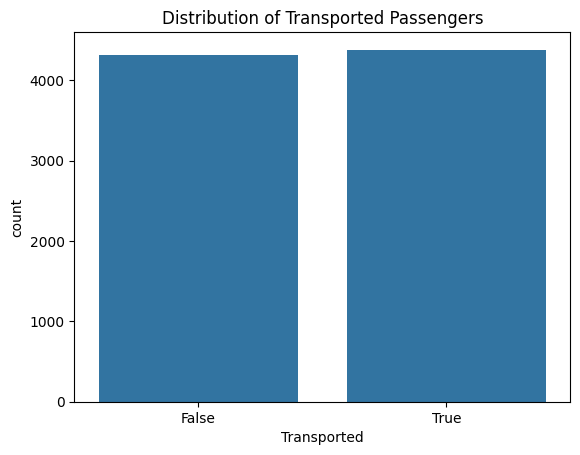

In [4]:
# It's good practice to handle boolean formatting for plots
combined_df['Transported'] = combined_df['Transported'].astype(bool)
train_df['Transported'] = train_df['Transported'].astype(bool)
plt.title('Distribution of Transported Passengers')
sns.countplot(data=train_df, x="Transported")

Question: Does your HomePlanet affect your chance of being Transported?

Visualization: A count plot using the hue parameter.

<Axes: title={'center': 'Transported vs. HomePlanet'}, xlabel='Transported', ylabel='count'>

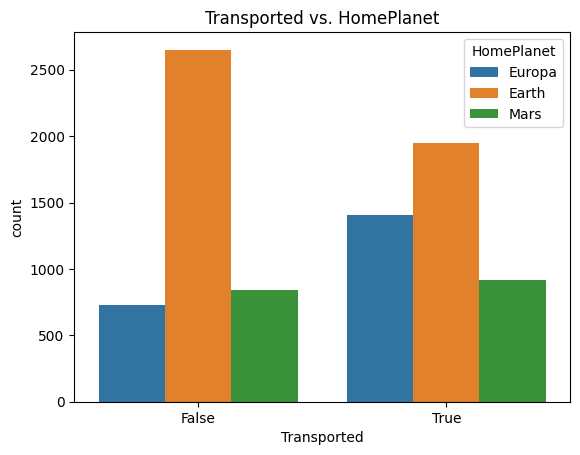

In [5]:
plt.title('Transported vs. HomePlanet')
sns.countplot(data=train_df, x="Transported", hue="HomePlanet")

<Axes: title={'center': 'Age Distribution by Transported Status'}, xlabel='Age', ylabel='Count'>

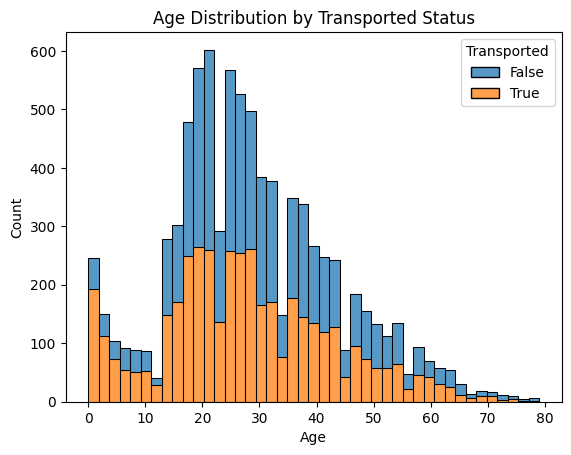

In [6]:
plt.title('Age Distribution by Transported Status')
sns.histplot(data=train_df, x='Age', hue='Transported', multiple='stack')

In [7]:
# For CryoSleep and VIP, assume missing values = False
combined_df['CryoSleep'] = combined_df['CryoSleep'].fillna(False).astype(bool)
combined_df['VIP'] = combined_df['VIP'].fillna(False).astype(bool)

/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_86930/1583993901.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['CryoSleep'] = combined_df['CryoSleep'].fillna(False).astype(bool)
/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_86930/1583993901.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['VIP'] = combined_df['VIP'].fillna(False).astype(bool)


In [8]:
# Feature Engineering, Total Spend column
# Combines all money spent into one column
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Assume null is 0 spent for all null cols
# combined_df[spending_cols] = combined_df[spending_cols].fillna(0)
# combined_df['TotalSpend'] = combined_df[spending_cols].sum(axis=1)

# Smarter way is assuming anyone in CryoSleep spent 0, then take the median for anyone else
# Better to use loc over queries here
combined_df.loc[combined_df['CryoSleep'] == True, spending_cols] = combined_df.loc[combined_df['CryoSleep'] == True, spending_cols].fillna(0)

for col in spending_cols:
    median_spend = combined_df.loc[combined_df['CryoSleep'] == False, col].median()
    combined_df[col].fillna(median_spend, inplace=True)

combined_df['TotalSpend'] = combined_df[spending_cols].sum(axis=1)
combined_df.head()

/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_86930/2756641414.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df[col].fillna(median_spend, inplace=True)
/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_86930/2756641414.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0


Text(0.5, 1.0, 'Total Spend by Transported Status (Log Scale)')

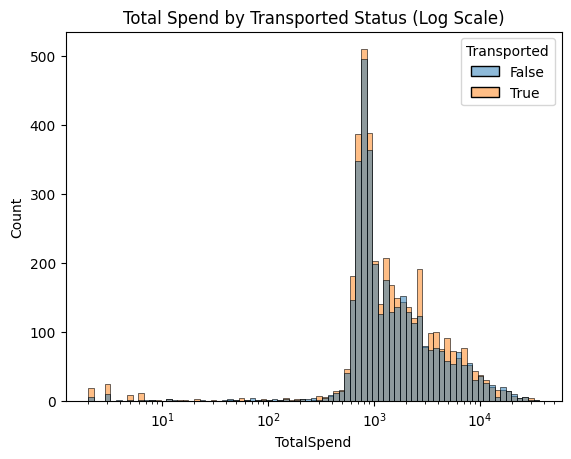

In [9]:
sns.histplot(data=combined_df, x='TotalSpend', hue='Transported', log_scale=True)
plt.title('Total Spend by Transported Status (Log Scale)')

In [10]:
combined_df.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep         0
Cabin           299
Destination     274
Age             270
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            294
Transported       0
TotalSpend        0
dtype: int64

In [11]:
# Extract features from Cabin
# Fill the null values with unknown, apart form cabin num which can be 0
combined_df['Cabin'].fillna('Unknown/0/Unknown', inplace=True)

combined_df[['Deck', 'CabinNum', 'Side']] = combined_df['Cabin'].str.split('/', expand=True)
combined_df.head()

/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_86930/3258355581.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Cabin'].fillna('Unknown/0/Unknown', inplace=True)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpend,Deck,CabinNum,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,F,1,S


In [12]:
# Fill missing age values as the median
combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)

combined_df['Destination'].fillna(combined_df['Destination'].mode()[0], inplace=True)
combined_df['HomePlanet'].fillna(combined_df['HomePlanet'].mode()[0], inplace=True)

/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_86930/3354095320.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Age'].fillna(combined_df['Age'].median(), inplace=True)
/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_86930/3354095320.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

In [13]:
# Extracting group from the id
combined_df['Group'] = combined_df['PassengerId'].str.split('_', expand=True)[0]
combined_df['GroupSize'] = combined_df.groupby('Group').transform('size')

In [14]:
# Making group size into categories
combined_df['GroupType'] = 'SmallGroup'
combined_df.loc[combined_df['GroupSize'] == 1, 'GroupType'] = 'Solo'
combined_df.loc[combined_df['GroupSize'] > 4, 'GroupType'] = 'LargeGroup'

In [15]:
# Making age into categories, generally better as the age and survial might not be linear
age_bins = [0, 12, 18, 25, 50, 100]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
combined_df['AgeGroup'] = pd.cut(combined_df['Age'], bins=age_bins, labels=age_labels)

In [16]:
combined_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,TotalSpend,Deck,CabinNum,Side,Group,GroupSize,GroupType,AgeGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,0.0,B,0,P,0001,1,Solo,Adult
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,736.0,F,0,S,0002,1,Solo,Young Adult
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,10383.0,A,0,S,0003,2,SmallGroup,Senior
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Solam Susent,False,5176.0,A,0,S,0003,2,SmallGroup,Adult
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Willy Santantines,True,1091.0,F,1,S,0004,1,Solo,Teen


<Axes: xlabel='AgeGroup', ylabel='Transported'>

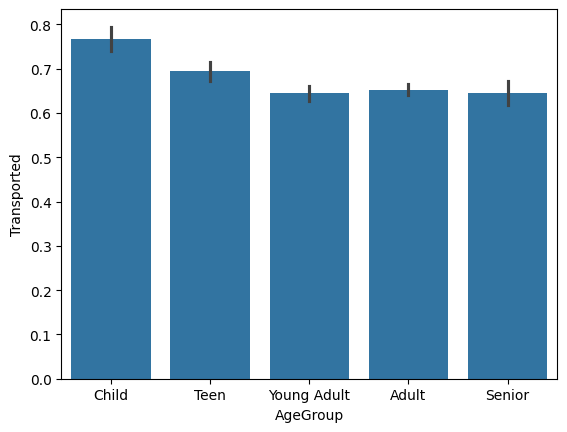

In [17]:
sns.barplot(data=combined_df, x='AgeGroup', y='Transported')

In [18]:
# Column for if they spent no money at all
combined_df['NoSpend'] = (combined_df['TotalSpend'] == 0).astype(int)

In [19]:
# Sometimes a combination of two features is more predictive than one
combined_df['Deck_Planet'] = combined_df['Deck'].astype(str) + '_' + combined_df['HomePlanet'].astype(str)

In [20]:
# Also add some more detailed group features
combined_df['Group_Avg_Age'] = combined_df.groupby('Group')['Age'].transform('mean')
combined_df['Group_Total_Spend'] = combined_df.groupby('Group')['TotalSpend'].transform('sum')

In [21]:
combined_df.drop(columns=['Cabin', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Age', 'Group', 'GroupSize'], inplace=True)

In [22]:
combined_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Transported,TotalSpend,Deck,CabinNum,Side,GroupType,AgeGroup,NoSpend,Deck_Planet,Group_Avg_Age,Group_Total_Spend
0,0001_01,Europa,False,TRAPPIST-1e,False,False,0.0,B,0,P,Solo,Adult,1,B_Europa,39.0,0.0
1,0002_01,Earth,False,TRAPPIST-1e,False,True,736.0,F,0,S,Solo,Young Adult,0,F_Earth,24.0,736.0
2,0003_01,Europa,False,TRAPPIST-1e,True,False,10383.0,A,0,S,SmallGroup,Senior,0,A_Europa,45.5,15559.0
3,0003_02,Europa,False,TRAPPIST-1e,False,False,5176.0,A,0,S,SmallGroup,Adult,0,A_Europa,45.5,15559.0
4,0004_01,Earth,False,TRAPPIST-1e,False,True,1091.0,F,1,S,Solo,Teen,0,F_Earth,16.0,1091.0


In [23]:
# One-hot encoding
# Category columns: HomePlanet, Destination
# Drop first = true drops the first column to avoid redundacny , like if its not mars nor europa then it has to be earth (earth not stored)
# Dont include group as its too big
combined_df = pd.get_dummies(combined_df, columns=['HomePlanet', 'Destination', 'Deck', 'Side', 'AgeGroup', 'Deck_Planet', 'GroupType'], drop_first=True)

In [24]:
combined_df.head()

,PassengerId,CryoSleep,VIP,Transported,TotalSpend,CabinNum,NoSpend,Group_Avg_Age,Group_Total_Spend,HomePlanet_Europa,...,Deck_Planet_F_Earth,Deck_Planet_F_Mars,Deck_Planet_G_Earth,Deck_Planet_T_Earth,Deck_Planet_T_Europa,Deck_Planet_Unknown_Earth,Deck_Planet_Unknown_Europa,Deck_Planet_Unknown_Mars,GroupType_SmallGroup,GroupType_Solo
0,0001_01,False,False,False,0.0,0,1,39.0,0.0,True,...,False,False,False,False,False,False,False,False,False,True
1,0002_01,False,False,True,736.0,0,0,24.0,736.0,False,...,True,False,False,False,False,False,False,False,False,True
2,0003_01,False,True,False,10383.0,0,0,45.5,15559.0,True,...,False,False,False,False,False,False,False,False,True,False
3,0003_02,False,False,False,5176.0,0,0,45.5,15559.0,True,...,False,False,False,False,False,False,False,False,True,False
4,0004_01,False,False,True,1091.0,1,0,16.0,1091.0,False,...,True,False,False,False,False,False,False,False,False,True


In [25]:
# Feature Scaling

# Initialize the Scaler
scaler = StandardScaler()

# List of columns to scale
cols_to_scale = ['TotalSpend', 'CabinNum', 'Group_Avg_Age', 'Group_Total_Spend']

# Apply the scaler to the columns
combined_df[cols_to_scale] = scaler.fit_transform(combined_df[cols_to_scale])

In [26]:
# Convert bools and string nums to ints 
combined_df['CryoSleep'] = combined_df['CryoSleep'].astype(int)
combined_df['VIP'] = combined_df['VIP'].astype(int)
combined_df['Transported'] = combined_df['Transported'].astype(int)
combined_df['CabinNum'] = combined_df['CabinNum'].astype(int)
combined_df['NoSpend'] = combined_df['NoSpend'].astype(int)

In [27]:
combined_df.head()

,PassengerId,CryoSleep,VIP,Transported,TotalSpend,CabinNum,NoSpend,Group_Avg_Age,Group_Total_Spend,HomePlanet_Europa,...,Deck_Planet_F_Earth,Deck_Planet_F_Mars,Deck_Planet_G_Earth,Deck_Planet_T_Earth,Deck_Planet_T_Europa,Deck_Planet_Unknown_Earth,Deck_Planet_Unknown_Europa,Deck_Planet_Unknown_Mars,GroupType_SmallGroup,GroupType_Solo
0,0001_01,0,0,0,-0.510624,-1,1,0.861327,-0.552588,True,...,False,False,False,False,False,False,False,False,False,True
1,0002_01,0,0,1,-0.248449,-1,0,-0.397320,-0.413650,False,...,True,False,False,False,False,False,False,False,False,True
2,0003_01,0,1,0,3.187969,-1,0,1.406741,2.384551,True,...,False,False,False,False,False,False,False,False,True,False
3,0003_02,0,0,0,1.333151,-1,0,1.406741,2.384551,True,...,False,False,False,False,False,False,False,False,True,False
4,0004_01,0,0,1,-0.121992,-1,0,-1.068598,-0.346635,False,...,True,False,False,False,False,False,False,False,False,True


In [28]:
# Separate the test data (for final submission) before defining X and y
# The test data is all rows where 'Transported' is still missing
final_test_df = combined_df[combined_df['Transported'].isnull()].drop('Transported', axis=1)

# The training data is all rows where 'Transported' is not missing
final_train_df = combined_df.dropna(subset=['Transported'])

# Create your features X and target y from the training data
X = final_train_df.drop(['Transported', 'PassengerId'], axis=1) 
y = final_train_df['Transported']

# Keep the PassengerId for the test set for the submission file
test_passenger_ids = final_test_df['PassengerId']
X_test = final_test_df.drop('PassengerId', axis=1) 

In [29]:
# Chose to use Logistic regression as baseline first
logistic_model = LogisticRegression(random_state=42)

# Cross Validation
logistic_cv_scores = cross_val_score(logistic_model, X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {logistic_cv_scores}")
print(f"Average CV Accuracy: {logistic_cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {logistic_cv_scores.std():.4f}")

Cross-Validation Accuracy Scores: [0.67579029 0.67309175 0.6692367  0.56283732 0.62490362]
Average CV Accuracy: 0.6412
Standard Deviation of CV Accuracy: 0.0434


In [30]:
# Random forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross Validation
random_forest_cv_scores = cross_val_score(random_forest_model, X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {random_forest_cv_scores}")
print(f"Average CV Accuracy: {random_forest_cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {random_forest_cv_scores.std():.4f}")

Cross-Validation Accuracy Scores: [0.65265998 0.654202   0.60678489 0.51619121 0.5693909 ]
Average CV Accuracy: 0.5998
Standard Deviation of CV Accuracy: 0.0524


In [31]:
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_scores = cross_val_score(xgb_classifier, X, y, cv=5, scoring='accuracy')

print(f"Baseline XGBoost CV Accuracy: {xgb_scores.mean():.4f} +/- {xgb_scores.std():.4f}")


/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:54] WARN

Baseline XGBoost CV Accuracy: 0.5813 +/- 0.0571


/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [32]:
# Tune the XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1]
}


# Initialize GridSearchCV with the XGBClassifier
xgb_grid_search = GridSearchCV(estimator=xgb_classifier,
                               param_grid=xgb_param_grid,
                               cv=5,
                               verbose=1,
                               n_jobs=-1)

# Fit the grid search to the data
xgb_grid_search.fit(X, y)

print(f"Best XGBoost Hyperparameters: {xgb_grid_search.best_params_}")
print(f"Best XGBoost CV Score: {xgb_grid_search.best_score_:.4f}")

xgb_best = xgb_grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:56] WARN

Best XGBoost Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best XGBoost CV Score: 0.6604


/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [33]:
# Initialize the LightGBM model
lgbm = LGBMClassifier(random_state=42)

# Get the cross-validation score
lgbm_scores = cross_val_score(lgbm, X, y, cv=5, scoring='accuracy')

print(f"Baseline LightGBM CV Accuracy: {lgbm_scores.mean():.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6924, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 10376, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.667309 -> initscore=0.696040
[LightGBM] [Info] Start training from score 0.696040
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6924, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

In [34]:
# Define a parameter grid for LightGBM
lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [20, 31, 40] # A key parameter for LightGBM
}

# Set up and run the grid search
lgbm_grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_param_grid, cv=5, scoring='accuracy')
lgbm_grid_search.fit(X, y)

print(f"Tuned LightGBM Best Score: {lgbm_grid_search.best_score_:.4f}")
print(f"Best Parameters: {lgbm_grid_search.best_params_}")

# Get the best estimator
lgbm_best = lgbm_grid_search.best_estimator_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6924, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 10376, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.667309 -> initscore=0.696040
[LightGBM] [Info] Start training from score 0.696040
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6924, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

In [35]:
# # Stacking LGBM and XGB, not good perfromance in this case so removed it

# # Create the list of base models
# estimators = [
#     ('xgb', xgb_best),
#     ('lgbm', lgbm_best)
# ]

# # Initialize the Stacking Classifier with a final meta-model
# stacking_model = StackingClassifier(
#     estimators=estimators, 
#     final_estimator=LogisticRegression(),
#     cv=5 # Use cross-validation within the stacking itself
# )

# # Get a final cross-validation score for the entire stack
# stacking_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='accuracy')

# print(f"Stacked Model CV Accuracy: {stacking_scores.mean():.4f}")

In [36]:
# Feature Selection with our XGBoost model
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importances.head(15))

# Select top 20 features
top_features = feature_importances['feature'].head(20).tolist()


                      feature  importance
4                     NoSpend    0.270482
0                   CryoSleep    0.235940
2                  TotalSpend    0.189245
16                     Deck_G    0.067045
7           HomePlanet_Europa    0.040036
35         Deck_Planet_E_Mars    0.032144
14                     Deck_E    0.016403
37         Deck_Planet_F_Mars    0.015037
41  Deck_Planet_Unknown_Earth    0.014663
29       Deck_Planet_C_Europa    0.010147
12                     Deck_C    0.009486
19                     Side_S    0.009465
44       GroupType_SmallGroup    0.008375
10    Destination_TRAPPIST-1e    0.007979
3                    CabinNum    0.007813


In [37]:
new_scores = cross_val_score(xgb_best, X[top_features], y, cv=5)
print(f"Score with Top 20 Features: {new_scores.mean():.4f}")

/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:28] WARN

Score with Top 20 Features: 0.6602


/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [38]:
# Initialize the final model with the best parameters found by GridSearchCV

final_model = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=0.7,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model on the entire training dataset
final_model.fit(X, y)

# Make predictions
final_predictions = final_model.predict(X_test)

submission_df = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': final_predictions.astype(bool) # Convert 0/1 back to True/False
})

submission_df['PassengerId'] = submission_df['PassengerId'].astype(str)

# index=False is crucial for the submission to be accepted by Kaggle
submission_df.to_csv('data/submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")


/Users/harridavies/Desktop/Spaceship-Titanic/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Submission file 'submission.csv' created successfully!
